In [1]:
# importing libraries
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

2025-08-17 06:11:07.029703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755411067.215570      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755411067.270818      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# reading files
train_df = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Train.csv")
test_df  = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")

train_df.head(), test_df.head()

(   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
 0     27      26       5       5      22      20       20   
 1     28      27       5       6      23      22       20   
 2     29      26       6       5      24      21       20   
 3     28      27       5       6      23      22       20   
 4     28      26       5       5      23      21       20   
 
                              Path  
 0  Train/20/00020_00000_00000.png  
 1  Train/20/00020_00000_00001.png  
 2  Train/20/00020_00000_00002.png  
 3  Train/20/00020_00000_00003.png  
 4  Train/20/00020_00000_00004.png  ,
    Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
 0     53      54       6       5      48      49       16  Test/00000.png
 1     42      45       5       5      36      40        1  Test/00001.png
 2     48      52       6       6      43      47       38  Test/00002.png
 3     27      29       5       5      22      24       33  Test/00003.png
 4     60      57       5   

In [3]:
# preprocessing
img_size = 32
num_classes = train_df['ClassId'].nunique()

X = []
y = []

for i, row in train_df.iterrows():
    img = cv2.imread(os.path.join("/kaggle/input/gtsrb-german-traffic-sign", row['Path']))
    img = cv2.resize(img, (img_size, img_size))
    X.append(img)
    y.append(row['ClassId'])

In [4]:
X = np.array(X, dtype="float32") / 255.0
y = to_categorical(y, num_classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (31367, 32, 32, 3)
Validation shape: (7842, 32, 32, 3)


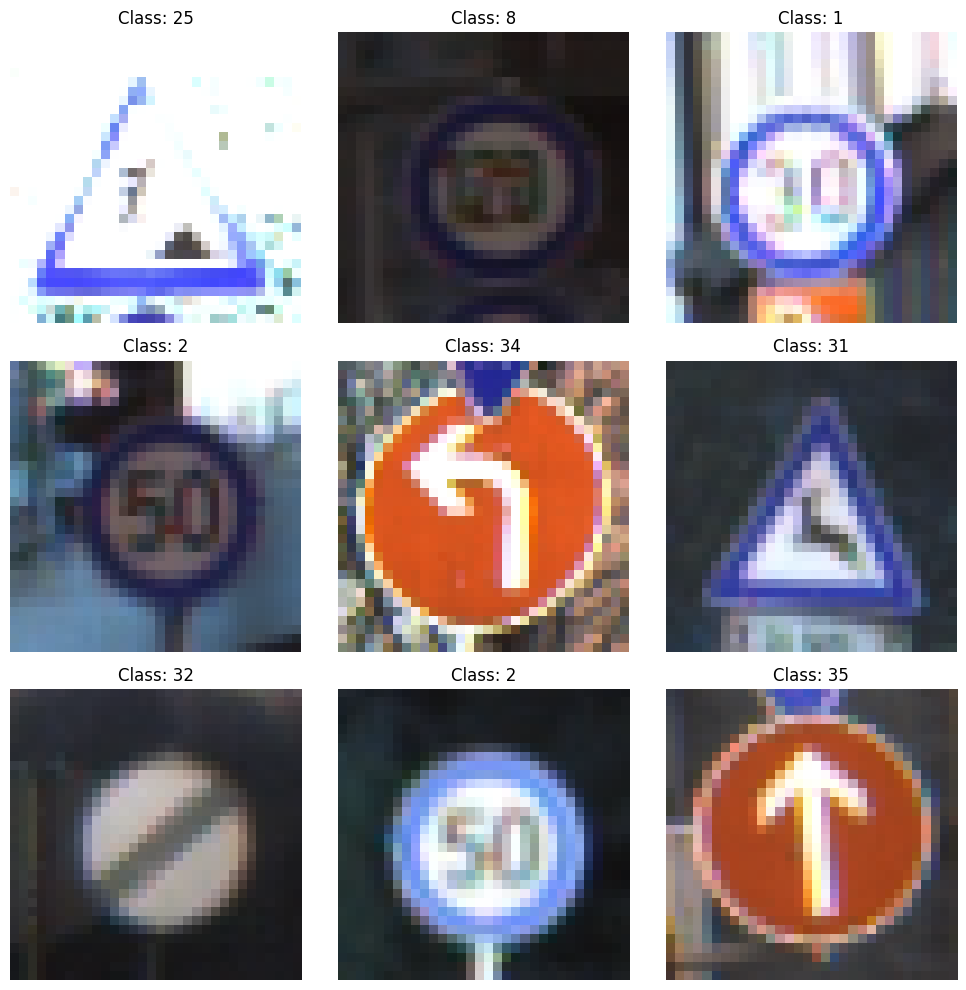

In [6]:
import random
num_images = 9
indices = random.sample(range(X_train.shape[0]), num_images)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[idx])
    plt.title(f"Class: {np.argmax(y_train[idx])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# model = Sequential()

# # 1st Convolutional Block
# model.add(Conv2D(32, (3,3), activation='softmax', input_shape=(img_size, img_size, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# # 2nd Convolutional Block
# model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# # 3rd Convolutional Block
# model.add(Conv2D(128, (3,3), activation='tanh', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# # 4th Convolutional Block
# model.add(Conv2D(256, (3,3), activation='sigmoid', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))


# # Flatten and Dense Layers
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# output using these blocks :
# Epoch 30/30
# 491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9955 - loss: 0.0189 - val_accuracy: 0.9944 - val_loss: 0.0321

# close to relu activation in all blocks, but relu was slightly better

In [8]:
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Block
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Block
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755411500.274679      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755411500.275377      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629,739 (2.40 MB)

 Trainable params: 629,291 (2.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# training model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=30,
    verbose=1
)

Epoch 1/30


I0000 00:00:1755411506.112418     104 service.cc:148] XLA service 0x7a7a40013090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755411506.113051     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755411506.113066     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755411506.518044     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 38/491 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0961 - loss: 4.3380

I0000 00:00:1755411509.819658     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.4300 - loss: 2.2174 - val_accuracy: 0.9097 - val_loss: 0.3145
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9378 - loss: 0.1991 - val_accuracy: 0.9770 - val_loss: 0.0707
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9713 - loss: 0.0887 - val_accuracy: 0.9728 - val_loss: 0.0838
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9778 - loss: 0.0713 - val_accuracy: 0.9944 - val_loss: 0.0211
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9868 - loss: 0.0455 - val_accuracy: 0.9876 - val_loss: 0.0442
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9836 - loss: 0.0545 - val_accuracy: 0.9819 - val_loss: 0.0595
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9861 - loss: 0.0469 - val_accuracy: 0.9898 - val_loss: 0.0373
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9901 - va

In [12]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


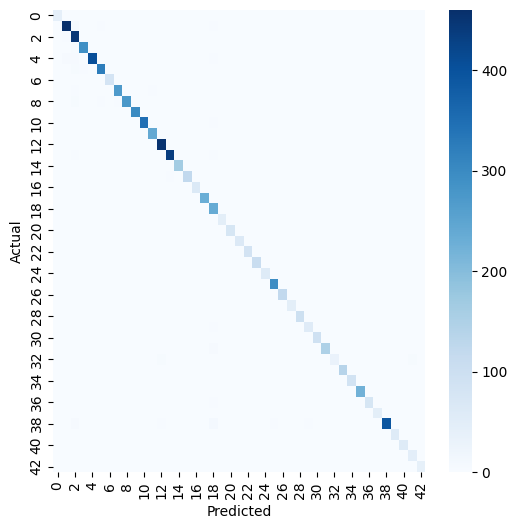

In [13]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.97      0.97      0.97       474
           2       0.92      0.99      0.95       452
           3       0.99      0.99      0.99       295
           4       1.00      0.96      0.98       420
           5       0.98      0.98      0.98       332
           6       0.98      1.00      0.99        82
           7       0.99      0.98      0.99       276
           8       1.00      0.97      0.98       283
           9       1.00      0.98      0.99       304
          10       1.00      0.99      1.00       349
          11       0.98      0.99      0.99       242
          12       0.98      1.00      0.99       454
          13       0.99      0.99      0.99       441
          14       1.00      1.00      1.00       167
          15       0.99      0.96      0.98       127
          16       1.00      1.00      1.00        65
          17       1.00    

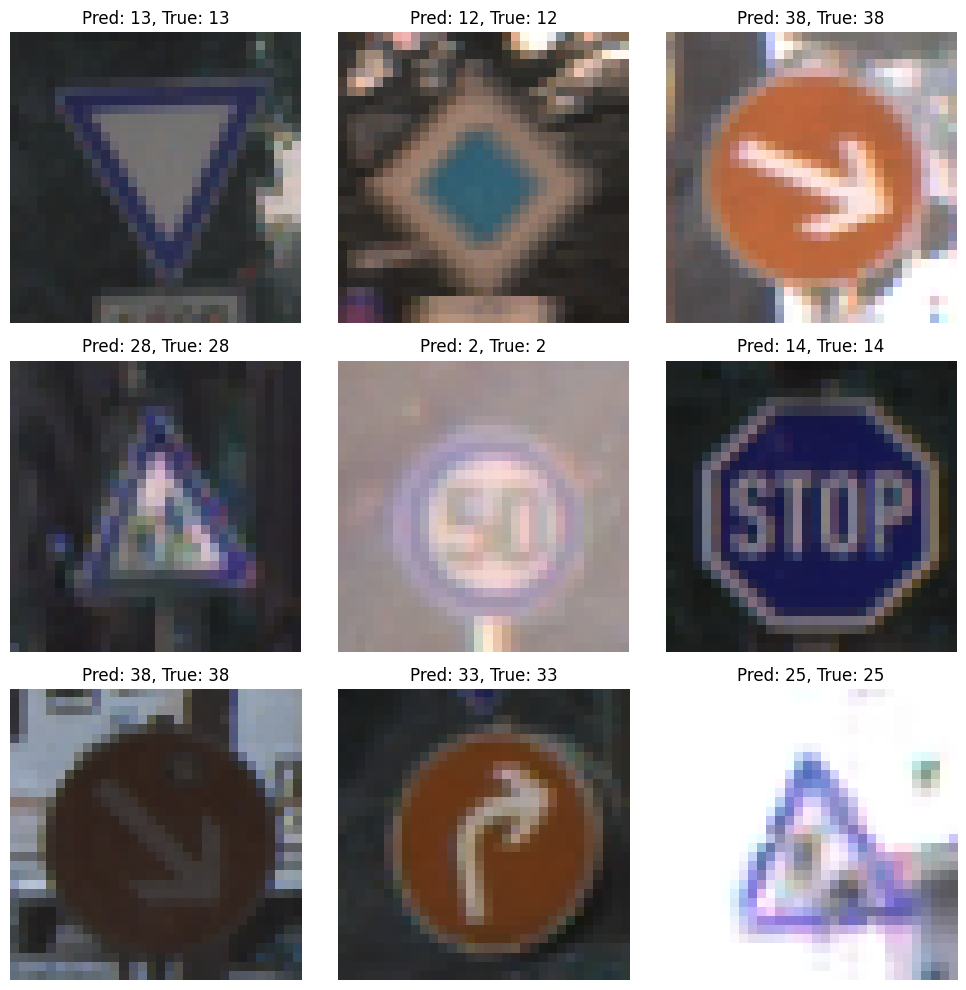

In [15]:
num_images = 9
indices = random.sample(range(X_val.shape[0]), num_images)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    plt.imshow(X_val[idx])
    plt.title(f"Pred: {y_pred_classes[idx]}, True: {y_true[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# data augmentation bonus part
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

In [17]:
historyWithDA = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.8431 - loss: 0.9080 - val_accuracy: 0.9936 - val_loss: 0.0213
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9438 - loss: 0.2133 - val_accuracy: 0.9974 - val_loss: 0.0071
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9611 - loss: 0.1438 - val_accuracy: 0.9976 - val_loss: 0.0072
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9664 - loss: 0.1172 - val_accuracy: 0.9974 - val_loss: 0.0101
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9749 - loss: 0.0885 - val_accuracy: 0.9969 - val_loss: 0.0112
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9760 - loss: 0.0889 - val_accuracy: 0.9976 - val_loss: 0.0098
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9789 - loss: 0.0807 - val_accuracy: 0.9968 - val_loss: 0.0110
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9794 - loss: 0.0740 - val_accurac

### The traditional CNN ***without*** data augmentation was slightly better than the Cnn ***with*** data augmentation

In [18]:
# pre-trained model (MobileNetv2) bonus part
img_size_mobilenet = 64

X_mn = []
for i, row in train_df.iterrows():
    img = cv2.imread(os.path.join("/kaggle/input/gtsrb-german-traffic-sign", row['Path']))
    img = cv2.resize(img, (img_size_mobilenet, img_size_mobilenet))
    X_mn.append(img)

In [19]:
X_mn = np.array(X_mn, dtype="float32")
X_mn = preprocess_input(X_mn)

In [20]:
y_mn = to_categorical(train_df['ClassId'].values, num_classes)
X_train_mn, X_val_mn, y_train_mn, y_val_mn = train_test_split(X_mn, y_mn, test_size=0.2, random_state=42)

In [21]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size_mobilenet, img_size_mobilenet, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

/tmp/ipykernel_36/1176312983.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size_mobilenet, img_size_mobilenet, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,596,971 (9.91 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history_mn = mobilenet_model.fit(
    X_train_mn, y_train_mn,
    validation_data=(X_val_mn, y_val_mn),
    batch_size=64,
    epochs=30,
    verbose=1
)

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.3878 - loss: 2.2560 - val_accuracy: 0.6961 - val_loss: 0.9436
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6748 - loss: 1.0035 - val_accuracy: 0.7723 - val_loss: 0.7129
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7512 - loss: 0.7579 - val_accuracy: 0.8184 - val_loss: 0.5872
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7965 - loss: 0.6132 - val_accuracy: 0.8331 - val_loss: 0.5216
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8223 - loss: 0.5424 - val_accuracy: 0.8453 - val_loss: 0.4767
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8505 - loss: 0.4475 - val_accuracy: 0.8586 - val_loss: 0.4444
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8623 - loss: 0.4071 - val_accuracy: 0.8666 - val_loss: 0.4155
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8777 - loss: 0.3635 - val_accu

In [29]:
y_pred_mn = np.argmax(mobilenet_model.predict(X_val_mn), axis=1)
y_true_mn = np.argmax(y_val_mn, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


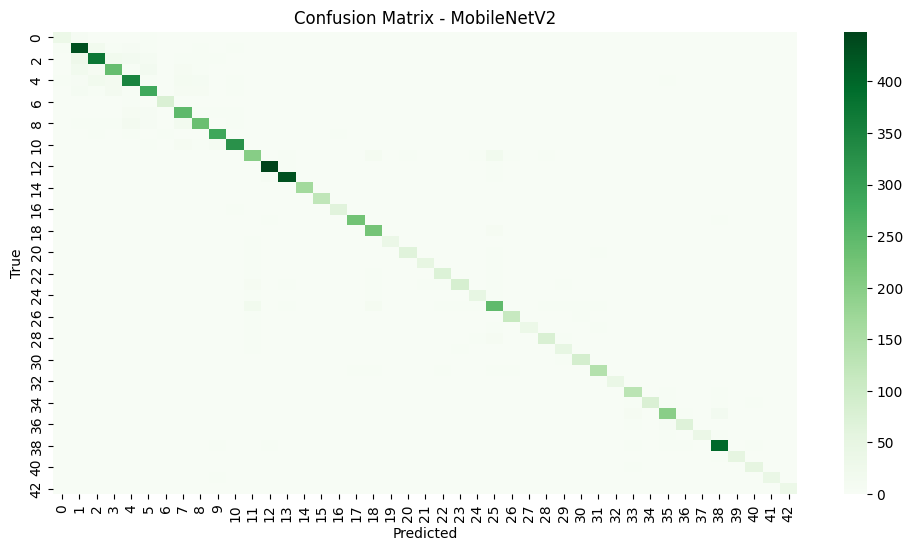

In [31]:
# MobileNet Confusion Matrix
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_true_mn, y_pred_mn), cmap="Greens", annot=False)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [32]:
print("MobileNetV2 Classification Report:")
print(classification_report(y_true_mn, y_pred_mn))

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        44
           1       0.86      0.91      0.88       474
           2       0.87      0.82      0.84       452
           3       0.82      0.81      0.81       295
           4       0.86      0.83      0.85       420
           5       0.86      0.86      0.86       332
           6       0.96      0.95      0.96        82
           7       0.82      0.89      0.86       276
           8       0.87      0.83      0.85       283
           9       0.91      0.94      0.93       304
          10       0.95      0.93      0.94       349
          11       0.77      0.83      0.80       242
          12       0.96      0.99      0.97       454
          13       0.96      0.97      0.97       441
          14       0.99      0.99      0.99       167
          15       0.99      0.98      0.98       127
          16       0.97      0.97      0.97   

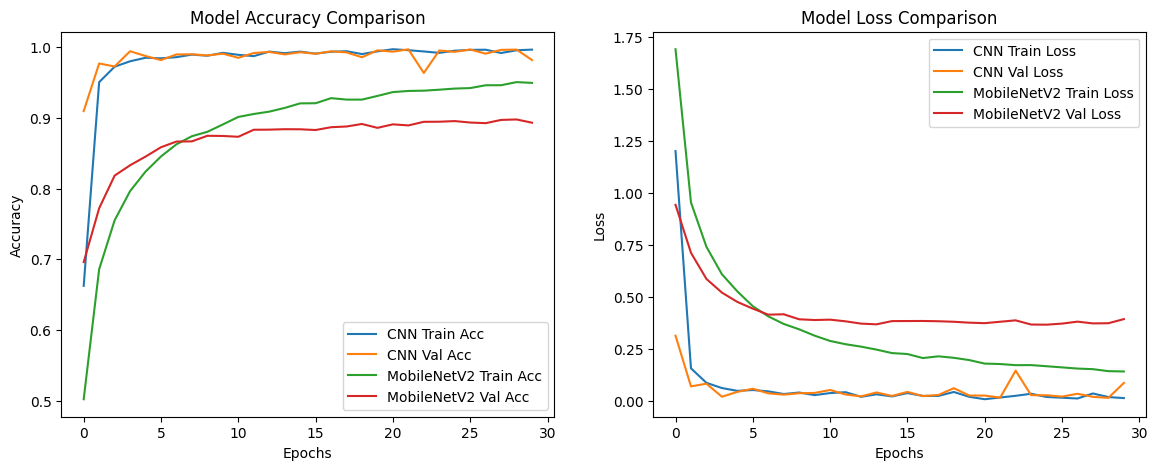

In [35]:
# CNN vs MobileNetv2 comparison
plt.figure(figsize=(14,5))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='CNN Train Acc')
plt.plot(history.history['val_accuracy'], label='CNN Val Acc')
plt.plot(history_mn.history['accuracy'], label='MobileNetV2 Train Acc')
plt.plot(history_mn.history['val_accuracy'], label='MobileNetV2 Val Acc')
plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='CNN Train Loss')
plt.plot(history.history['val_loss'], label='CNN Val Loss')
plt.plot(history_mn.history['loss'], label='MobileNetV2 Train Loss')
plt.plot(history_mn.history['val_loss'], label='MobileNetV2 Val Loss')
plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()